# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
def get_radius(mass):
    """
    Calculate and return the radius of a star given its mass.

    Parameters:
    mass (float): The mass of the star.

    Returns:
    float: The radius of the star.
    """
    return mass * 0.03

In [2]:
# Class: star
class Star():
    """
    A class used to represent a star.

    Attributes
    ----------
    name : str
        The name of the star.
    giant : bool
        Whether the star is a hypergiant or not.
    mass : float
        The mass of the star.
    starting_position : numpy.ndarray
        The starting position of the star.
    starting_velocity : numpy.ndarray
        The starting velocity of the star.
    radius : float
        The radius of the star.
    """

    def __init__(self, name, giant=False, mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([0,0])):
        assert isinstance(name, str), "Name must be of type string"
        assert isinstance(giant, bool), "Giant must be of type bool"
        assert starting_position.shape == (2,), "Starting position must be a 2D vector"
        assert starting_velocity.shape == (2,), "Starting velocity must be a 2D vector"
        assert mass > 0, 'mass must be positive'

        self.name = name
        self.giant = giant
        self.mass = mass
        self.starting_position = starting_position
        self.starting_velocity = starting_velocity
        self._get_radius = get_radius

        # radius depends on whether the star is a giant or not
        if self.giant:
            self.radius = self._get_radius(self.mass)
        else:
            self.radius = 0

In [3]:
# Stellar systems
class Stellar_System():
    """
    A class used to represent a stellar system.

    Attributes
    ----------
    name : str
        The name of the stellar system.
    integration_method : str
        The integration method to use.
    list_of_stars : numpy.ndarray
        The list of stars in the system.
    y_solution : numpy.ndarray
        The solution to the system of ODEs.
    t_solution : numpy.ndarray
        The time solution.
    max_time : float
        The maximum time to integrate to.
    N_time_steps : int
        The number of time steps to use.
    
    Methods
    -------
    add_star(star)
        Add a star to the system.
    calculate_movement()
        Calculate the movement of the stars in the system.
    plot_movement(ax, plot_centre_of_mass=False)
        Plot the movement of the stars in the system.
    """

    integration_methods = ["RK45", "MidPoint"]

    def __init__(self, max_time=50,  N_time_steps=250 , integration_method='RK45', name=''):
        # Integration parameters
        self._is_defined = False
        self._max_time = max_time
        self._N_time_steps = N_time_steps
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)
        self._integration_method = integration_method
        assert self.integration_method in self.integration_methods, 'Integration method not supported - choose either RK45 or MidPoint'
        assert self.max_time > 0, 'max_time must be positive'
        assert self.N_time_steps > 0, 'N_time_steps must be positive'

        # Stellar system parameters
        self.name = name
        assert isinstance(self.name, str), 'Name must be of type string'
        self._hypergiants = False
        self._g = 1

        # Star variables
        self._list_of_stars = np.array([], dtype=Star)
        self._list_of_giants = np.array([], dtype=bool)
        self._masses = np.array([], dtype=float)
        self._radii = np.array([], dtype=float)
        self._assimilated = np.array([], dtype=bool)
        self._collision_coordinates = np.empty((0,2), float)

    @property
    def y_solution(self):
        return self._y_solution
    
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time
    
    @property
    def N_time_steps(self):
        return self._N_time_steps
    
    @property
    def list_of_stars(self):
        return self._list_of_stars
    
    @property
    def integration_method(self):
        return self._integration_method

    def add_star(self, star):
        """
        Add a star to the system.

        Parameters:
        star (Star): The star to add to the system.
        """
        assert isinstance(star, Star), 'Star must be of type Star'

        if star.giant == True:
            # Make the system one of hypergiants
            self._hypergiants = True
            
            # Ensure hypergiants are the largest stars in the system
            if len(self._list_of_giants) > 0:
                assert np.all([i.mass < star.mass for i in self._list_of_stars[[not b for b in self._list_of_giants]]]), 'Hypergiants must be the most massive stars in the system'
            assert self.integration_method == "MidPoint", "Hypergiants can only be simulated using the MidPoint method"
        else:
            # Ensure hypergiants are the largest stars in the system
            if len(self._list_of_giants) > 0:
                assert np.all([i.mass > star.mass for i in self._list_of_stars[self._list_of_giants]]), 'Hypergiants must be the most massive stars in the system'
        
        # Update system variables
        self._list_of_stars = np.append(self._list_of_stars, star)
        self._list_of_giants = np.append(self._list_of_giants, star.giant)
        self._masses = np.append(self._masses, star.mass)
        self._masses_over_time = self._masses
        self._radii = np.append(self._radii, star.radius)
        self._assimilated = np.append(self._assimilated, False)
        
        # Define system if there are at least two stars
        if len(self._list_of_stars) > 1:
            self._is_defined = True

    def _solve_odes(self, t, conditions, half_step=False):
        """
        Solve the system of ODEs.

        Parameters:
        t (float): The time.
        conditions (numpy.ndarray): The conditions.
        half_step (bool): Whether to use half step or not.

        Returns:
        numpy.ndarray: The solution to the system of ODEs.
        """
        # Initialise dydt
        dydt = np.zeros_like(conditions)

        if not half_step:
            # Check for collisions
            if self._hypergiants:

                for index1, _ in enumerate(self._list_of_stars):

                    for index2, _ in enumerate(self._list_of_stars):

                        if index1 != index2 and self._assimilated[index1] == 0 and self._assimilated[index2] == 0:

                            # Check if distance is less than the sum of the radii
                            if np.sqrt(sum((conditions[4*index1:4*index1 + 2] - conditions[4*index2:4*index2 + 2])**2)) < sum(self._radii[[index1, index2]]):
                                # Find the index of the smaller star
                                index_small = [index1, index2][np.argmin(self._radii[[index1, index2]])]
                                # Find the index of the larger star
                                index_large = np.abs(index_small - 1)

                                # Calculate the new mass and radius of the larger star
                                new_mass = self._masses[index_small] + self._masses[index_large]
                                new_radius = get_radius(new_mass)
                                new_velocity = (self._masses[index_small] * conditions[4*index_small + 2:4*index_small + 4] + self._masses[index_large] * conditions[4*index_large + 2:4*index_large + 4]) / new_mass

                                # Make the smaller star mass, radius, velocity, and position 0
                                self._masses[index_small] = 0
                                self._radii[index_small] = 0
                                conditions[4*index_small:4*index_small + 4] = np.array([0, 0, 0, 0])
                                self._assimilated[index_small] = True

                                # Update collision coordinates
                                colliision_coordinate = (conditions[4*index_small:4*index_small + 2] * self._radii[index_small] + conditions[4*index_large:4*index_large + 2] * self._radii[index_large]) / (self._radii[index_small] + self._radii[index_large])
                                self._collision_coordinates = np.vstack([self._collision_coordinates, colliision_coordinate])

                                # Update the larger star mass, radius, velocity, and position
                                self._masses[index_large] = new_mass
                                self._radii[index_large] = new_radius
                                conditions[4*index_large:4*index_large + 4] = np.array([conditions[4*index_large + 0], conditions[4*index_large + 1], new_velocity[0], new_velocity[1]])

            # Save the masses at this time step
            self._masses_over_time = np.vstack([self._masses_over_time, self._masses])

        # ODEs
        for index, _ in enumerate(self._list_of_stars):
            # If star has been assimilated, set all conditions to 0
            if self._assimilated[index]:
                conditions[4*index:4*index + 4] = np.array([0, 0, 0, 0])
                dydt[4*index:4*index + 4] = np.array([0, 0, 0, 0])
            
            # If the star is the only one left, no forces act on it
            elif sum(self._assimilated) == len(self._list_of_stars) - 1:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = 0
                dydt[4*index + 3] = 0

            # If the star is not the only one left, calculate the forces acting on it
            else:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = - self._g * sum(self._masses[i] * (conditions[4*index + 0] - conditions[4*i + 0]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)
                dydt[4*index + 3] = - self._g * sum(self._masses[i] * (conditions[4*index + 1] - conditions[4*i + 1]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)

        return dydt
    

    def _integrate_using_midpoint(self, dydt_function, y0):
        """
        Integrate the system of ODEs using the MidPoint method.

        Parameters:
        dydt_function (function): The function to integrate.
        y0 (numpy.ndarray): The initial conditions.
        """
        # Initialise the solution
        self._y_solution = np.zeros((len(self._t_solution), len(y0)))
        
        for itime, time in enumerate(self._t_solution) :
            if itime == 0:
                self._y_solution[itime] = np.array(y0)
            else :
                y_at_t_over_2 = self._y_solution[itime-1] + (1/2) * self._delta_t * dydt_function(time, self._y_solution[itime-1], half_step=True)

                self._y_solution[itime] = self._y_solution[itime-1] +  self._delta_t * dydt_function(time + self._delta_t, y_at_t_over_2)

        self._y_solution = self._y_solution.transpose()
   

    def calculate_movement(self):
        """
        Calculate the movement of the stars in the system. The solution is stored in y_solution.
        """
        assert self._is_defined, "System is not defined, add at least two stars"

        # Initial conditions
        initial_conditions = np.zeros(len(self._list_of_stars) * 4)    
        for index, star in enumerate(self._list_of_stars):
            initial_conditions[4*index + 0] = star.starting_position[0]
            initial_conditions[4*index + 1] = star.starting_position[1]
            initial_conditions[4*index + 2] = star.starting_velocity[0]
            initial_conditions[4*index + 3] = star.starting_velocity[1]

        # Solve ODEs
        if self.integration_method == 'RK45':
            # Get the solution
            self._y_solution = solve_ivp(self._solve_odes, [0, self.max_time], initial_conditions, t_eval=self._t_solution, method='RK45', rtol=1e-10).y
        if self.integration_method == 'MidPoint':
            self._integrate_using_midpoint(self._solve_odes, initial_conditions)
    
    def plot_movement(self, ax, plot_centre_of_mass=False):
        """
        Plot the movement of the stars in the system.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        plot_centre_of_mass (bool): Whether to plot the centre of mass of the system or not.
        """
        # Plot the centre of mass if needed
        if plot_centre_of_mass:
            if not self._hypergiants:
                # Calculation and plotting if collision is not allowed
                centre_of_mass = np.array([sum(self._masses[i] * self._y_solution[4*i +j] for i, _ in enumerate(self._list_of_stars)) / np.sum(self._masses) for j in range(2)])

                # Plot the centre of mass either as a point or a line
                if np.abs(centre_of_mass[0][0] - centre_of_mass[0][-1]) < 0.000001 and np.abs(centre_of_mass[1][0] - centre_of_mass[1][-1]) < 0.000001:
                    ax.scatter(centre_of_mass[0][0], centre_of_mass[1][0], label='Centre of mass', color='r')
                else:
                    ax.plot(centre_of_mass[0], centre_of_mass[1], label='Centre of mass', color='r')
            
            else:
                # Calculation and plotting if collision is allowed
                centre_of_mass = np.array([[np.dot(self._masses_over_time[i], self._y_solution[j::4,i]) / sum(self._masses_over_time[i]) for j in range(2)] for i in range(len(self._y_solution[0]))])
                
                # Plot the centre of mass either as a point or a line
                if np.abs(centre_of_mass[0][0] - centre_of_mass[-1][0]) < 0.000001 and np.abs(centre_of_mass[0][1] - centre_of_mass[-1][1]) < 0.000001:
                    ax.scatter(centre_of_mass[0][0], centre_of_mass[0][1], label='Centre of mass', color='r')
                else:
                    ax.plot(centre_of_mass[:,0], centre_of_mass[:,1], label='Centre of mass', color='r')

        if self._hypergiants:
            # Plot the collision coordinates
            if len(self._collision_coordinates) > 0:
                ax.scatter(self._collision_coordinates[:,0], self._collision_coordinates[:,1], label='Collision', color='k')

        # Plot the star trajectories
        for index, star in enumerate(self._list_of_stars):
                stop = len(self._y_solution[0])
                for i in range(len(self._y_solution[0])):
                    if self._y_solution[4*index + 0][i] == 0 and self._y_solution[4*index + 1][i] == 0 and self._y_solution[4*index + 2][i] == 0 and self._y_solution[4*index + 3][i] == 0:
                        stop = i
                        break
                ax.plot(self._y_solution[4*index + 0][:stop], self._y_solution[4*index + 1][:stop], label=star.name)
           
        ax.legend()

### Examples

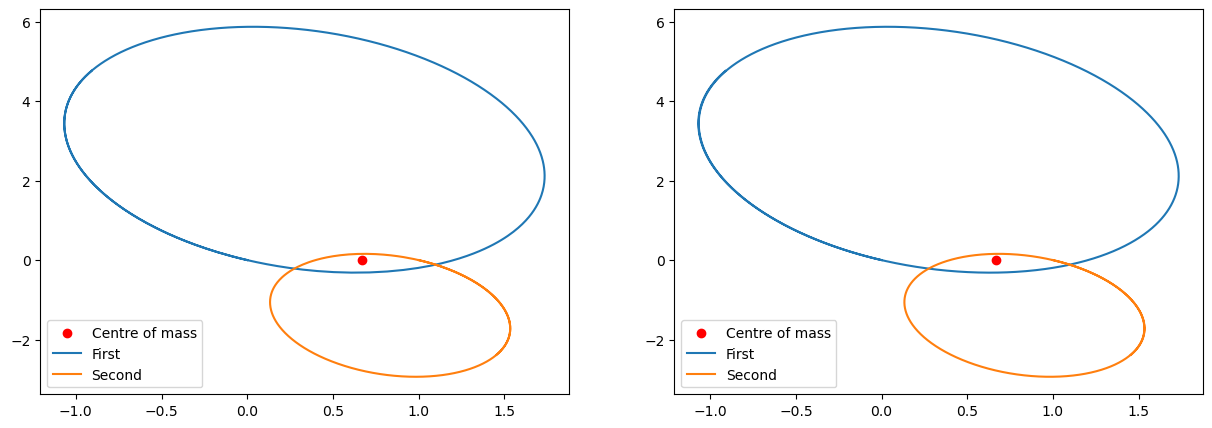

In [4]:
# 2-body problem [0,0,0,0.5] and [1,0,0,-0.5] work well
first_star = Star(name='First', mass=0.21, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = Star(name='Second', mass=0.42, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

my_stellar_system = Stellar_System(max_time=100, N_time_steps=1000, integration_method='RK45', name='Solar system')
my_stellar_system_2 = Stellar_System(max_time=100, N_time_steps=10000, integration_method='MidPoint', name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)

my_stellar_system_2.add_star(first_star)
my_stellar_system_2.add_star(second_star)

my_stellar_system.calculate_movement()
my_stellar_system_2.calculate_movement()

fig, ax = plt.subplots(1, 2, figsize=(15,5))

my_stellar_system.plot_movement(ax[0], plot_centre_of_mass=True)
my_stellar_system_2.plot_movement(ax[1], plot_centre_of_mass=True)

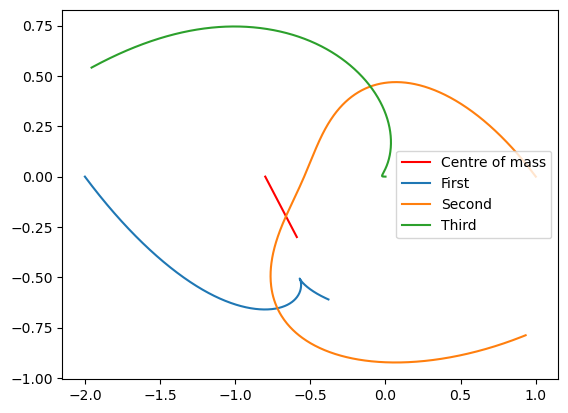

In [5]:
# 2-body problem [0,0,0,0.5] and [1,0,0,-0.5] work well
first_star = Star(name='First', mass=1, giant=True, starting_position=np.array([-2,0]), starting_velocity=np.array([.5,-.5]))
second_star = Star(name='Second', mass=0.4, starting_position=np.array([1,0]), starting_velocity=np.array([-0.75,0.75]))
third_star = Star(name='Third', mass=0.6, starting_position=np.array([0,0]), starting_velocity=np.array([-0.1,0]))

my_stellar_system = Stellar_System(max_time=3, N_time_steps=1000, integration_method='MidPoint', name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)
my_stellar_system.add_star(third_star)

my_stellar_system.calculate_movement()

fig, ax = plt.subplots(1, 1)

my_stellar_system.plot_movement(ax, plot_centre_of_mass=True)

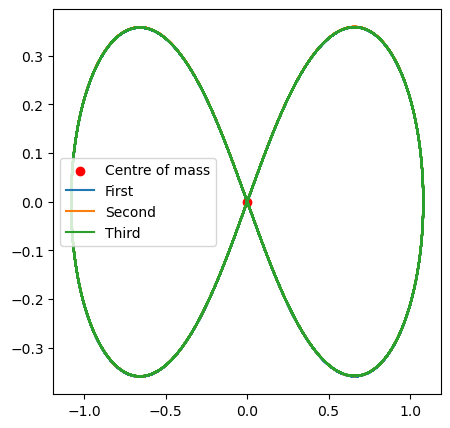

In [6]:
# 3-body problem

first_star = Star(name='First', mass=1, starting_position=np.array([0.97000436,-0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
second_star = Star(name='Second', mass=1, starting_position=np.array([-0.97000436,0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
third_star = Star(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-0.93240737,-0.86473146]))

my_stellar_system = Stellar_System(max_time=100, N_time_steps=10000, integration_method='MidPoint', name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)
my_stellar_system.add_star(third_star)

my_stellar_system.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(5,5))


my_stellar_system.plot_movement(ax, plot_centre_of_mass=True)

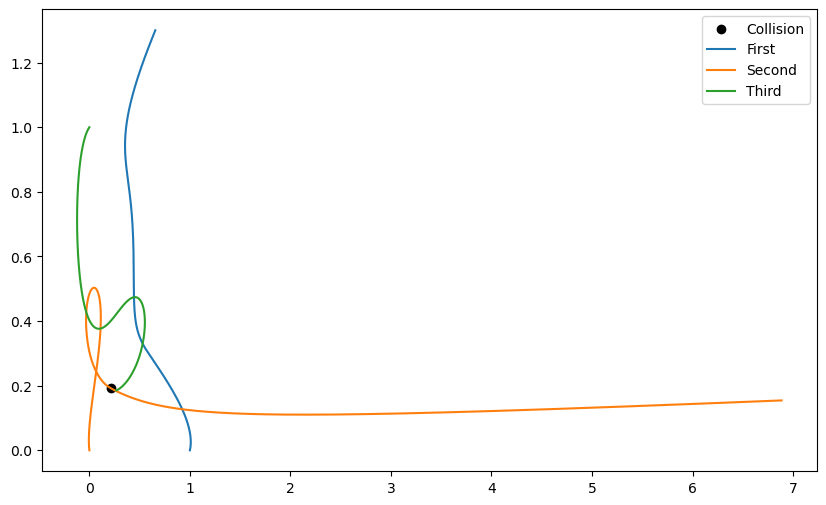

In [7]:
# 3-body problem - hypergiants
first_star = Star(name='First', mass=1.2, giant=True, starting_position=np.array([1, 0]), starting_velocity=np.array([0.15,0.2]))
second_star = Star(name='Second', mass=1, giant=True, starting_position=np.array([0,0]), starting_velocity=np.array([-0.11,0.29]))
third_star = Star(name='Third', mass=0.8, giant=True, starting_position=np.array([0,1]), starting_velocity=np.array([-0.4,-0.18]))

tbp_stellar_system = Stellar_System(max_time=3, N_time_steps=10000, integration_method="MidPoint", name='Solar system')

tbp_stellar_system.add_star(first_star)
tbp_stellar_system.add_star(second_star)
tbp_stellar_system.add_star(third_star)

tbp_stellar_system.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,6))

tbp_stellar_system.plot_movement(ax, plot_centre_of_mass=False)